In [1]:
import pymongo as py
import pandas as pd
import datetime
import pprint
import matplotlib.pyplot as plt
import numpy as np

client = py.MongoClient('localhost', 27017)
db = client['Stocks']

In [2]:
def get_stock_dataframe(stock, features, start_date, end_date, db):
    
    c = db[stock]
    cols = ['Date'] + features
    df = pd.DataFrame([], columns=cols)
    
    for thing in c.find():
        date = thing['Date']
        if date > start_date and date < end_date:

            ans = [None for _ in range(len(features))]
            
            for i in range(len(features)):
                try:
                    ans[i] = thing[features[i]]
                except:
                    pass
            
            ans=[date]+ans     
            row = pd.DataFrame([ans], columns=cols)      
            df = df.append(row)
    
    df = df.set_index('Date')
    df = df.sort_index()
    return df

In [3]:
def get_annual_datapoint(stock, features, year, db):
    
    c = db[stock]
    cols = ['Date'] + features
    ans = [None for _ in range(len(features))]
    
    for thing in c.find():
        date = thing['Date']
        if date.year == year: 
            for i in range(len(features)):
                try:
                    ans[i] = thing[features[i]]
                except:
                    pass

    return ans

In [4]:
def get_annual_features_dataframe(stocks, features, year, db):
    
    cols = ['Stock'] + features
    df = pd.DataFrame([], columns=cols)
    
    for stock in stocks:
        data = get_annual_datapoint(stock, features, year, db)
        
        ans = [stock] + data
        row = pd.DataFrame([ans], columns=cols)      
        df = df.append(row)
    
    return df

In [5]:
# returns for 1996 are (1996 end price - 1995 end price (1996 start price))/1995 price
def calc_returns(stocks, year, db):
        
    cols = ['Stock', 'Returns']
    df = pd.DataFrame([], columns=cols)
    
    for stock in stocks:
        old = get_annual_datapoint(stock, ["LAST_PRICE"], year-1, db)
        new = get_annual_datapoint(stock, ["LAST_PRICE"], year, db)
        old_price = old[0]
        new_price = new[0]
        r = None
        try:
            r = (new_price - old_price) / old_price
        except:
            pass
        ans = [stock, r]
        row = pd.DataFrame([ans], columns=cols)      
        df = df.append(row)
    
    return df

In [6]:
# EBIDTA / market cap
def calc_adjusted_ebidta(stocks, year, db):
    cols = ['Stock', 'Adjusted EBIDTA']
    df = pd.DataFrame([], columns=cols)
    
    for stock in stocks:
        eb = get_annual_datapoint(stock, ['EBIDTA'], year, db)
        mc = get_annual_datapoint(stock, ['MARKET_CAP'], year, db)
        ebidta = eb[0]
        mcap = mc[0]
        r = None
        try:
            r = ebidta/mcap
        except:
            pass
        ans = [stock, r]
        row = pd.DataFrame([ans], columns=cols)      
        df = df.append(row)
    
    return df

In [7]:
# 1996 <= year <= 2017
def compare_returns(year, sp500_returns, r2000_returns, all_stocks, db):
    
    rdf = calc_returns(all_stocks, year, db)
    rdf = rdf.sort_values(by=['Returns'], ascending=False).head(20)
    ideal = rdf['Returns'].sum()/20
    
    edf = get_annual_features_dataframe(all_stocks, ['EBITDA'], year, db)
    edf = edf.sort_values(by='EBITDA', ascending=False).head(20)
    edf_r = calc_returns(edf['Stock'], year, db)
    test = edf_r['Returns'].sum()/20

    aedf = calc_adjusted_ebidta(all_stocks, year, db)
    aedf = aedf.sort_values(by='Adjusted EBIDTA', ascending=False).head(20)
    aedf_r = calc_returns(aedf['Stock'], year, db)
    test2 = aedf_r['Returns'].sum()/20
    
    return ideal, test, test2

In [8]:
# from http://www.1stock1.com/1stock1_141.htm
# from 1996 to 2017 (1995's annual ending price to 2017's annual ending price)
sp500_returns = [0.2026, 0.3101, 0.2667, 0.1953, -0.1014, -0.1304, -0.2337, 0.2638, 0.0899, 0.03, 0.1362,
                 0.0363, -0.3849, 0.2345, 0.1278, 0, 0.1341, 0.2960, 0.1139, -0.0073, 0.0954, 0.1942]

# from http://www.1stock1.com/1stock1_784.htm
# ditto
r2000_returns = [0.1476, 0.2052, -0.0345, 0.1962, -0.042, 0.0103, -0.2158, 0.4537, 0.17, 0.0332, 0.17,
                 -0.0275, -0.3480, 0.2522, 0.2531, -0.0545, 0.1463, 0.37, 0.0353, -0.0571, 0.1948, 0.1314]

years = range(1996, 2018)
stocks = db.list_collection_names()

i_points = [0 for _ in years]
t_points = [0 for _ in years]
n_points = [0 for _ in years]

for year in years:
    i, t, n = compare_returns(year, sp500_returns, r2000_returns, stocks, db)
    i_points[year-1996] = i
    t_points[year-1996] = t
    n_points[year-1996] = n

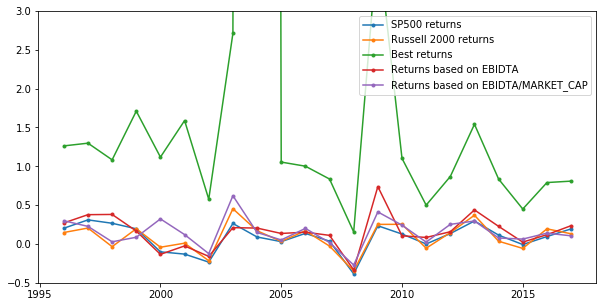

In [15]:
plt.figure(figsize=(10,5))
plt.ylim(-0.5, 3)
plt.plot(years, sp500_returns, marker='.')
plt.plot(years, r2000_returns, marker='.')
plt.plot(years, i_points, marker='.')
plt.plot(years, t_points, marker='.')
plt.plot(years, n_points, marker='.')
plt.legend(['SP500 returns', 'Russell 2000 returns', 'Best returns', 'Returns based on EBIDTA', 
            'Returns based on EBIDTA/MARKET_CAP'])
plt.show()

In [18]:
import numpy as np
print(n_points)
print(s_points)
diff = np.subtract(n_points, s_points)

print(diff)

[0.29905794693696597, 0.22633943916535965, 0.02795903852389896, 0.08651905695457565, 0.3227650556177179, 0.1207519555385725, -0.1244346801443879, 0.6213015355502062, 0.1480224599140505, 0.05209766191765849, 0.2003033195820271, 0.018024544891804408, -0.2710200590635955, 0.41257794763735633, 0.2423028988732729, 0.02442645599904699, 0.252529131124387, 0.295719304939161, 0.07692385421493368, 0.06301711171923936, 0.13920182001055306, 0.10499836667486118]
[0.2026, 0.3101, 0.2667, 0.1953, -0.1014, -0.1304, -0.2337, 0.2638, 0.0899, 0.03, 0.1362, 0.0363, -0.3849, 0.2345, 0.1278, 0, 0.1341, 0.296, 0.1139, -0.0073, 0.0954, 0.1942]
[ 9.64579469e-02 -8.37605608e-02 -2.38740961e-01 -1.08780943e-01
  4.24165056e-01  2.51151956e-01  1.09265320e-01  3.57501536e-01
  5.81224599e-02  2.20976619e-02  6.41033196e-02 -1.82754551e-02
  1.13879941e-01  1.78077948e-01  1.14502899e-01  2.44264560e-02
  1.18429131e-01 -2.80695061e-04 -3.69761458e-02  7.03171117e-02
  4.38018200e-02 -8.92016333e-02]


In [24]:
from scipy import stats
print(stats.ttest_1samp(diff, 0))

Ttest_1sampResult(statistic=2.1030771396229695, pvalue=0.04769126824944222)
